In [2]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [15]:
key_pts_frame = pd.read_csv("data/training_frames_keypoints.csv")

key_pts_frame.head()
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype("float").reshape(-1, 2)

In [16]:
print("Number of images: {}" .format(key_pts_frame.shape[0]))

Number of images: 3462


In [19]:
key_pts_frame.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


# Looking at some images

In [32]:
def show_keypoints(image, key_pts):
    '''Show image with keypoints'''
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker=".", c="m")

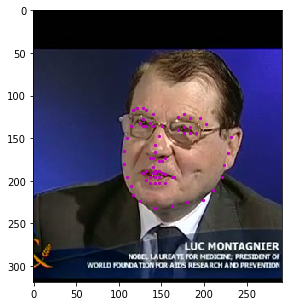

In [34]:
from random import randint
n = randint(0, key_pts_frame.shape[0])

image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype("float").reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join("data/training/", image_name)), key_pts)
plt.show()

# Dataset class and Transformations

In [35]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointDataset(Dataset):
    '''Face landmarks dataset'''
    
    def __init__(self, csv_file, root_dir, transform=None):
        '''
        Args:
            csv_file (string): path to location of csv
            root_dir (string): dir with all images
            transform (callable, optional): optional transform to be applied on a sample
        '''
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.key_pts_frame)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # If image has alpha color channel, remove
        if(image.shape[2] == 4):
            image = image[:, :, 0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = key_pts.astype("float").reshape(-1, 2)
        sample = {"image": image, "keypoints": key_pts}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [36]:
face_dataset = FacialKeypointDataset(csv_file="data/training_frames_keypoints.csv", root_dir="data/training/")

print("Lenght dataset: {}" .format(len(face_dataset)))

Lenght dataset: 3462


0 (241, 208, 3) (68, 2)
1 (315, 271, 3) (68, 2)
2 (227, 250, 3) (68, 2)


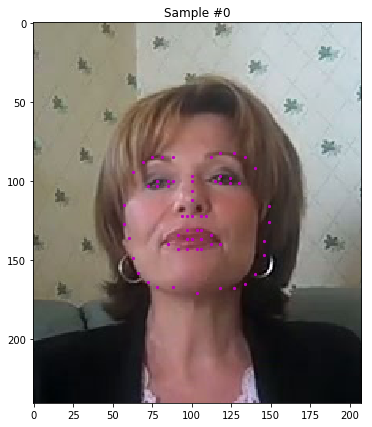

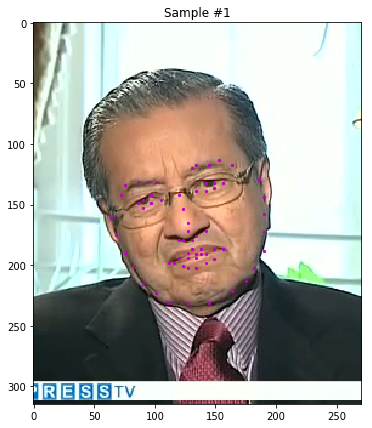

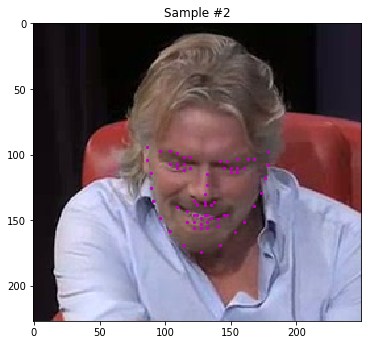

In [38]:
num_to_display = 3

for i in range(num_to_display):
    fig = plt.figure(figsize=(20, 10))
    
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]
    
    print(i, sample["image"].shape, sample["keypoints"].shape)
    
    ax = plt.subplot(1, num_to_display, i+1)
    ax.set_title("Sample #{}" .format(i))
    
    show_keypoints(sample["image"], sample["keypoints"])

# Transforms

In [43]:
import torch
from torchvision import transforms, utils

class Normalize(object):
    ''' Convert color img to grayscale and normalize [0-1]'''
    
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        
        img_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        
        img_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        img_copy = img_copy/255.0
        
        # Scale keypts to be centerend around 0 with range [-1, 1]
        # mean = 100, sqrt = 50
        key_pts_copy = (key_pts_copy - 100)/50.0
        
        return {"image": img_copy, "keypoints": key_pts_copy}
    
class Rescale(object):
    '''Rescale img in a sample to given size'''
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = cv2.resize(image, (new_w, new_h))
        
        # Scale the pts
        key_pts = key_pts * [new_w / w, new_h / h]
        
        return {"image": img, "keypoints": key_pts}

class RandomCrop(object):
    '''Crop randomly img in a sample'''
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h, left: left + new_w]
        
        key_pts = key_pts - [left, top]
        
        return {"image": image, "keypoints": key_pts}
    
class ToTensor(object):
    
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        
        if(len(image.shape) == 2):
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        image = image.transpose((2, 0, 1))
        
        return {"image": torch.from_numpy(image), "keypoints": torch.from_numpy(key_pts)}

# Test transform

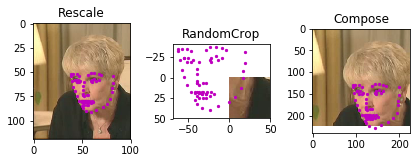

In [47]:
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250), RandomCrop(224)])

test_num = np.random.randint(0, 500)
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()